In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
# from torch.distributions import Normal, kl_divergence
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/train/"
transform_non_normal = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
dataset_non_normal = ImageFolder(root=image_dir, transform=transform_non_normal)
dataloader = DataLoader(dataset_non_normal, batch_size=32, shuffle=True)
print(len(dataloader)*32)

2912


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [35]:
class AE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128):
        super(AE, self).__init__()

        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 9, kernel_size=5, stride=4, padding=1),  # 3x512x512 -> 9x128x128
            nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.Conv2d(9, 18, kernel_size=5, stride=4, padding=1),  # 9x128x128 -> 18x32x32
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1),  # 18x32x32 -> 36x32x32
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),    # 36x32x32 -> 36x16x16

        )

        self.encoder_bottleneck = nn.Sequential(
            nn.Conv2d(36, 18, kernel_size=3, stride=1, padding=1),    # 36x16x16 -> 18x16x16
            nn.BatchNorm2d(18),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(4608, 4608),
            nn.ReLU(),
            nn.Unflatten(1, (18,16,16)),

            nn.ConvTranspose2d(18, 36, kernel_size=3, stride=1, padding=1, output_padding=0, dilation=1),   # 18x16x16 -> 36x16x16
            nn.BatchNorm2d(36),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(36, 36, kernel_size=2, stride=2, padding=0, output_padding=0), # 36x16x16 -> 36x32x32
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.ConvTranspose2d(36, 18, kernel_size=3, stride=1, padding=1, output_padding=0), # 36x32x32 -> 18x32x32
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.ConvTranspose2d(18, 9, kernel_size=4, stride=4, padding=0, output_padding=0), # 18x32x32 -> 9x128x128
            nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 9, kernel_size=4, stride=4, padding=0, output_padding=0), # 9x128x128 -> 3x512x512
            nn.BatchNorm2d(9),
            nn.ReLU(),

            

            nn.Conv2d(9, 3, kernel_size=1),               # 32x512x512 -> 3x512x512
            nn.Sigmoid()  
        )

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def bottleneck(self, x):
        z = self.encoder_bottleneck(x)
        return z

    def forward(self, x):
        x = self.encode(x)
        x = self.bottleneck(x)
        reconstructed = self.decode(x)
        return reconstructed

In [32]:
def ae_loss(reconstructed, original):
    # Reconstruction loss (e.g., MSE)
    recon_loss = F.mse_loss(reconstructed, original, reduction="sum")
    return recon_loss

In [36]:
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [37]:
summary(model, (3,512,512), batch_size=32, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 9, 128, 128]             684
       BatchNorm2d-2          [32, 9, 128, 128]              18
              ReLU-3          [32, 9, 128, 128]               0
            Conv2d-4           [32, 18, 32, 32]           4,068
       BatchNorm2d-5           [32, 18, 32, 32]              36
              ReLU-6           [32, 18, 32, 32]               0
            Conv2d-7           [32, 36, 32, 32]           5,868
       BatchNorm2d-8           [32, 36, 32, 32]              72
              ReLU-9           [32, 36, 32, 32]               0
        MaxPool2d-10           [32, 36, 16, 16]               0
           Conv2d-11           [32, 18, 16, 16]           5,850
      BatchNorm2d-12           [32, 18, 16, 16]              36
             ReLU-13           [32, 18, 16, 16]               0
          Flatten-14                 [3

In [38]:
def save_checkpoint(model, optimizer, epoch, file_path, losses):
    """
    Save the training state to a checkpoint file.

    Args:
        model: PyTorch model to save.
        optimizer: Optimizer used in training.
        epoch: Current epoch.
        file_path: Path to save the checkpoint.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': losses
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at {file_path}")

Epoch [40/100], Loss: 11136.6731


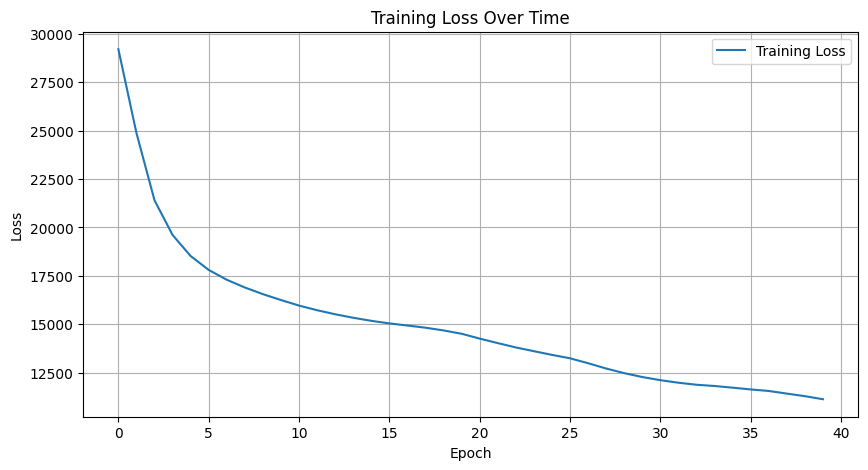

Checkpoint saved at C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver11_40_epochs_checkpoint.pth
Batch Count: 1
Batch Count: 2
Batch Count: 3
Batch Count: 4
Batch Count: 5
Batch Count: 6
Batch Count: 7
Batch Count: 8
Batch Count: 9
Batch Count: 10
Batch Count: 11
Batch Count: 12
Batch Count: 13
Batch Count: 14
Batch Count: 15
Batch Count: 16
Batch Count: 17
Batch Count: 18
Batch Count: 19
Batch Count: 20
Batch Count: 21
Batch Count: 22
Batch Count: 23
Batch Count: 24
Batch Count: 25
Batch Count: 26
Batch Count: 27
Batch Count: 28
Batch Count: 29
Batch Count: 30
Batch Count: 31
Batch Count: 32
Batch Count: 33
Batch Count: 34
Batch Count: 35
Batch Count: 36
Batch Count: 37
Batch Count: 38
Batch Count: 39
Batch Count: 40
Batch Count: 41
Batch Count: 42
Batch Count: 43
Batch Count: 44
Batch Count: 45
Batch Count: 46
Batch Count: 47
Batch Count: 48
Batch Count: 49
Batch Count: 50
Batch Count: 51
Batch Count: 52
Batch Count: 53
Batch Count: 54
Batch Count: 55
Batch Count: 5

KeyboardInterrupt: 

In [39]:
# Training

losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    count = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        # Forward pass
        reconstructed = model(images)
        
        loss = ae_loss(reconstructed, images)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        count += 1
        print(f"Batch Count: {count}")

    epoch_loss = round(train_loss / len(dataloader.dataset), 4)
    clear_output(wait=True)  # Clear the previous plot
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    losses.append(epoch_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    if (epoch+1) % 10 == 0:
        save_checkpoint(model, optimizer, epoch, f"C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver11_{epoch+1}_epochs_checkpoint.pth", losses)


In [ ]:
checkpoint_path = "C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver11_30_epochs_checkpoint.pth"

# Load checkpoint if resuming
if os.path.exists(checkpoint_path):  # Ensure file exists
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # Start from next epoch
    losses = checkpoint.get('losses', [])  # Load previous losses if available
    print(f"Resuming training from epoch {start_epoch+1}")
else:
    start_epoch = 0
    losses = []


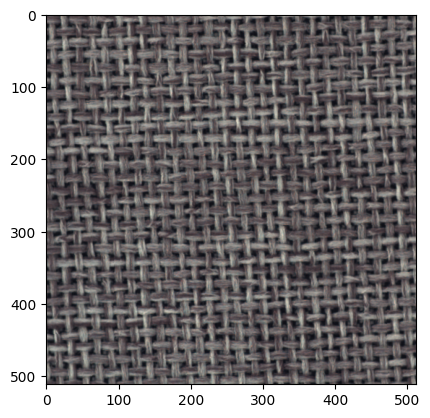

C:\Users\Gert\AppData\Local\Temp\ipykernel_7348\3950339196.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(output[0].cpu()).shape)


(3, 512, 512)
torch.Size([512, 512, 3])


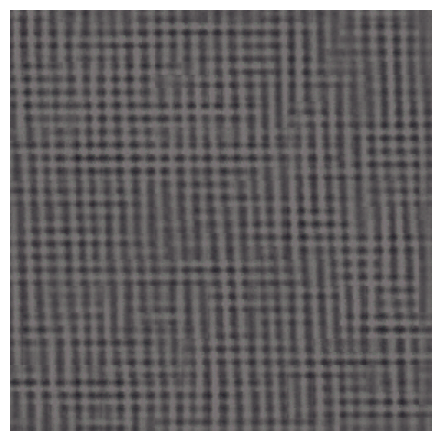

In [40]:
image = None
for i in dataloader:
    image = i
    break
# print(np.array(image[0][0]).shape)
image = image[0]
# print(image[0].reshape(512,512,-1).shape)
plt.imshow(image[0].permute(1, 2, 0))
plt.show()
# image_normalized = (image - mean[None, :, None, None]) / std[None, :, None, None]  # Normalize along the channel dimension

# Send the normalized image to the same device as the model (e.g., GPU or CPU)
image = image.to(device)
model = model.to(device)

# Run the image through the model
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(image)
print(np.array(output[0].cpu()).shape)
reconstructed_image = output[0]

reconstructed_image = reconstructed_image.permute(1, 2, 0).cpu()  # Convert (C, H, W) -> (H, W, C)
print(reconstructed_image.shape)
# Display the reconstructed image
plt.imshow(reconstructed_image.cpu().numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [41]:
test_image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/test"

test_dataset = ImageFolder(root=test_image_dir, transform=transform_non_normal)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

(3, 512, 512)


C:\Users\Gert\AppData\Local\Temp\ipykernel_7348\1842769413.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(image[0][0]).shape)


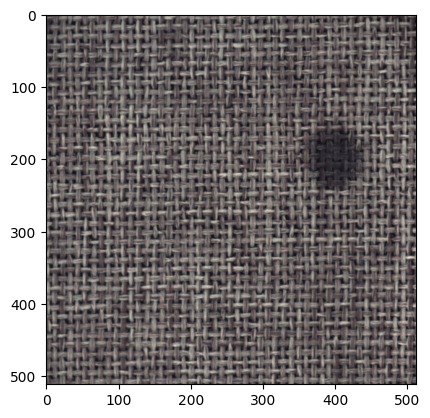

C:\Users\Gert\AppData\Local\Temp\ipykernel_7348\1842769413.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(image).shape)
C:\Users\Gert\AppData\Local\Temp\ipykernel_7348\1842769413.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(output[0].cpu()).shape)


(10, 3, 512, 512)
(3, 512, 512)


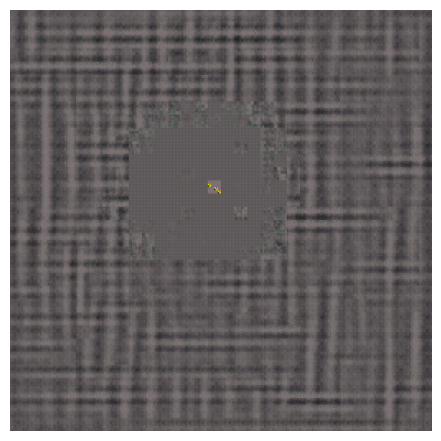

In [42]:
image = None
for i in test_dataloader:
    image = i
    break
print(np.array(image[0][0]).shape)
image = image[0]
plt.imshow(image[0].permute(1, 2, 0))
plt.show()
# image_normalized = (image - mean[None, :, None, None]) / std[None, :, None, None]  # Normalize along the channel dimension

print(np.array(image).shape)
# Send the normalized image to the same device as the model (e.g., GPU or CPU)
image = image.to(device)
model = model.to(device)

# Run the image through the model
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(image)
print(np.array(output[0].cpu()).shape)
reconstructed_image = output[0]

reconstructed_image = reconstructed_image.permute(1, 2, 0).cpu()  # Convert (C, H, W) -> (H, W, C)

# Display the reconstructed image
plt.imshow(reconstructed_image.cpu().numpy())
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()